In [12]:
import requests
url = "https://drive.google.com/uc?id=140fl292Ofs6tmEJzIFUPGo97AdIIO3vi&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
    f.write(r.content) 

In [13]:
!mkdir outputs

���� ���͸� �Ǵ� ���� outputs��(��) �̹� �ֽ��ϴ�.


In [14]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

In [15]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Overwriting coco_names.py


In [16]:
%%writefile detect_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image


Overwriting detect_utils.py


In [17]:
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils

from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model on to the computation device
model.eval().to(device)

# read the image and run the inference for detections
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

Overwriting detect_img.py


In [18]:
!python detect_img.py --input input/image_1.jpg
!python detect_img.py --input input/image_2.jpg

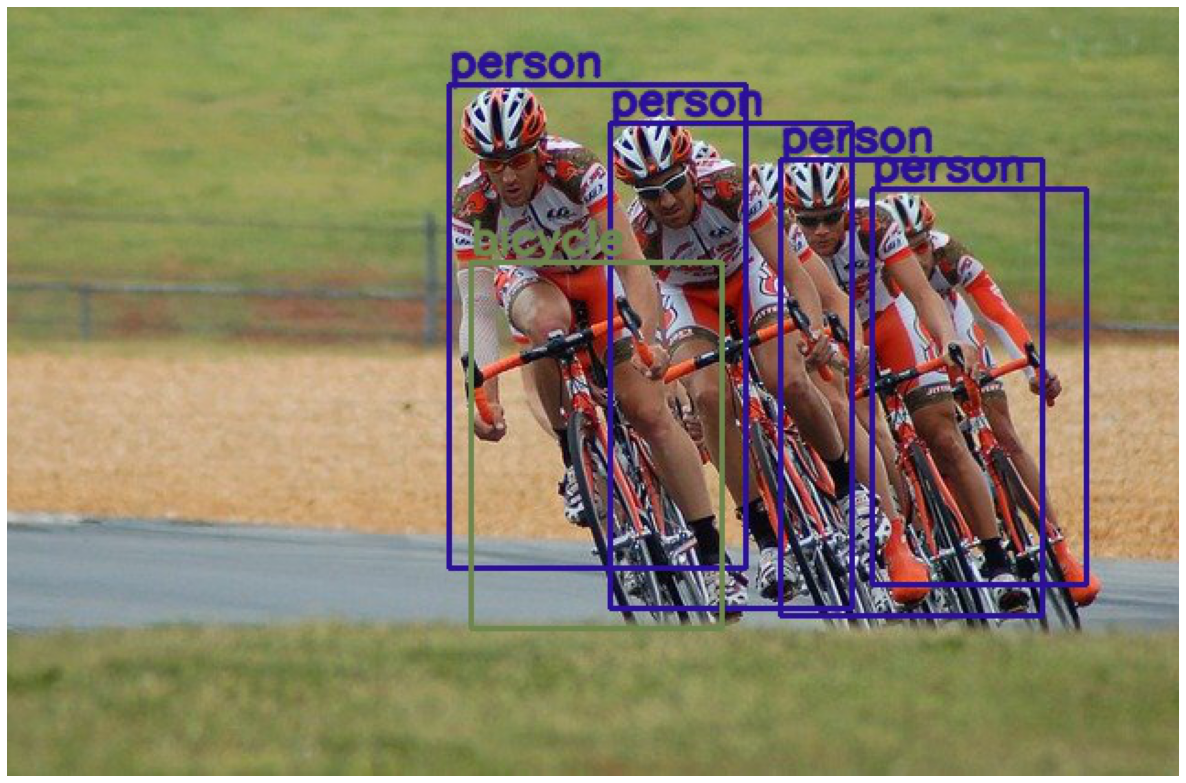

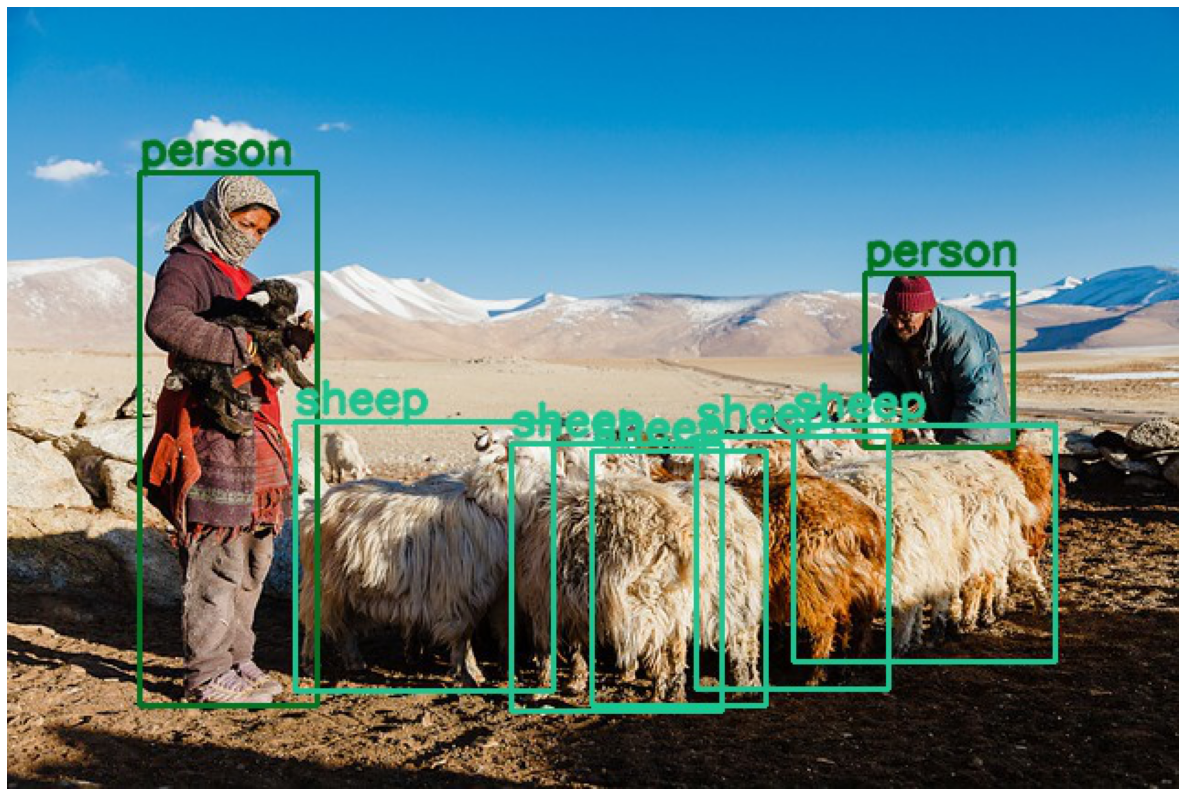

In [19]:
image_1 = plt.imread('outputs/image_1.jpg')
image_2 = plt.imread('outputs/image_2.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()

plt.imshow(image_2)
plt.axis('off')
plt.show()

In [20]:
%%writefile detect_vid.py
import torchvision
import cv2
import torch
import argparse
import time
import detect_utils

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model 
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model onto the computation device
model = model.eval().to(device)

cap = cv2.VideoCapture(args['input'])

if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"outputs/{save_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # get the start time
        start_time = time.time()
        with torch.no_grad():
            # get predictions for the current frame
            boxes, classes, labels = detect_utils.predict(frame, model, device, 0.7)
        
        # draw boxes and show current frame on screen
        image = detect_utils.draw_boxes(boxes, classes, labels, frame)

        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        print(f"Frame counter: {frame_count}, FPS: {fps}")
        # write the FPS on the current frame
        cv2.putText(image, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        # convert from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # cv2.imshow('image', image)
        out.write(image)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Overwriting detect_vid.py


In [21]:
!python detect_vid.py --input input/video_1.mp4

Error while trying to read video. Please check path again


Traceback (most recent call last):
  File "c:\KM LEE\MobileNet\detect_vid.py", line 83, in <module>
    avg_fps = total_fps / frame_count
ZeroDivisionError: division by zero


In [22]:
!python detect_vid.py --input input/video_2.mp4

Error while trying to read video. Please check path again


Traceback (most recent call last):
  File "c:\KM LEE\MobileNet\detect_vid.py", line 83, in <module>
    avg_fps = total_fps / frame_count
ZeroDivisionError: division by zero
